In [30]:
import numpy as np
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns

db = mysql.connector.connect(
    host="localhost",
    user="root",   
    password="root",
    database="ecommerce"           
)

cur = db.cursor()

In [28]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [29]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='root',
    database='ecommerce'
)
cursor = conn.cursor()

# ✅ Correct folder path
folder_path = r"C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project"

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

# Main Loop
for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    print(f"\nReading file: {file_path}")

    # Read CSV file
    df = pd.read_csv(file_path)

    # Replace NaN with None for MySQL compatibility
    df = df.where(pd.notnull(df), None)

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate CREATE TABLE statement
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame rows into MySQL
    for _, row in df.iterrows():
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    conn.commit()
    print(f"Inserted data into table: {table_name}")

# Close the connection
conn.close()

print("\nAll CSV files uploaded successfully!")



Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\customers.csv
Inserted data into table: customers

Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\orders.csv
Inserted data into table: orders

Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\sellers.csv
Inserted data into table: sellers

Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\products.csv
Inserted data into table: products

Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\geolocation.csv
Inserted data into table: geolocation

Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\payments.csv
Inserted data into table: payments

Reading file: C:\Users\Karanveer Singh\OneDrive\Documents\Ecommerce Project\order_items.csv
Inserted data into table: order_items

All CSV files uploaded successfully!


In [52]:
#List all unique cities where customers are located.
query = "Select distinct customer_city from customers"
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [ ]:
#Count the number of orders placed in 2017.
query = "Select count(order_id) from orders where year (order_purchase_timestamp)=2017"
cur.execute(query)
data = cur.fetchall()
data

[(45101,)]

In [41]:
#Find the total sales per category.
query = """
SELECT UPPER(products.product_category) AS category,
       ROUND(SUM(payments.payment_value), 2) AS sales
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Category','Sales'])
df


,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


In [47]:
#Calculate the percentage of orders that were paid in installments.
query = "Select (sum(case when payment_installments >=1 then 1 else 0 end))/count(*) *100 from payments"
cur.execute(query)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

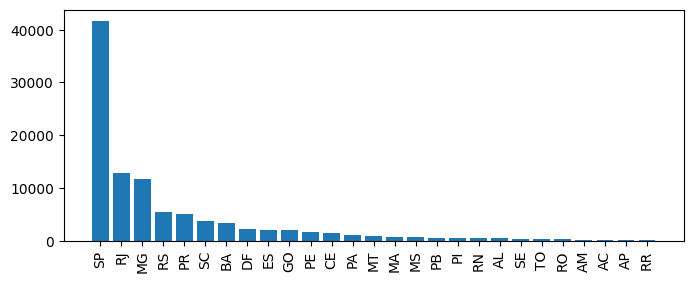

In [51]:
#Count the number of customers from each state.
query = "Select customer_state,count(customer_id) from customers group by customer_state"
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["State","Customer_Count"])
df = df.sort_values(by="Customer_Count",ascending=False)

plt.figure(figsize=(8,3))
plt.bar(df['State'],df['Customer_Count'])
plt.xticks(rotation=90)
plt.show()

In [55]:
#Calculate the number of orders per month in 2018.
query = "Select monthname(order_purchase_timestamp)months, count(order_id) order_count from orders where year(order_purchase_timestamp)=2018 group by months "
cur.execute(query)
data = cur.fetchall()
data

[('July', 6292),
 ('August', 6512),
 ('February', 6728),
 ('June', 6167),
 ('March', 7211),
 ('January', 7269),
 ('May', 6873),
 ('April', 6939),
 ('September', 16),
 ('October', 4)]

In [61]:
#Find the average number of products per order, grouped by customer city.

query = """
WITH count_per_order AS (
    SELECT 
        orders.order_id,
        orders.customer_id,
        COUNT(order_items.order_id) AS oc
    FROM orders
    JOIN order_items ON orders.order_id = order_items.order_id
    GROUP BY orders.order_id, orders.customer_id
)
SELECT 
    customers.customer_city,
    ROUND(AVG(count_per_order.oc), 2) AS average_orders
FROM customers
JOIN count_per_order 
    ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC;
"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=['customer_city', 'average_orders'])
df.head(10)


,customer_city,average_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


In [75]:
#Calculate the percentage of total revenue contributed by each product category.
query = """
SELECT UPPER(products.product_category) AS category,
       round((SUM(payments.payment_value)/(select sum(payment_value)from payments))*100,2) sales
FROM products
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category
order by sales desc;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ['Category','Percentage Distribution'])
#plt.pie(df['Percentage Distribution'], labels =df['Category'])
#plt.show()
df.head()
df

,Category,Percentage Distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


In [49]:
# Identify the correlation between product price and the number of times a product has been purchased.
import pandas as pd
import numpy as np

# create cursor from existing connection
cur = conn.cursor()

# SQL QUERY
query = """
SELECT 
    products.product_category,
    COUNT(order_items.product_id) AS total_purchases,
    ROUND(AVG(order_items.price), 2) AS avg_price
FROM products
JOIN order_items 
    ON products.product_id = order_items.product_id
GROUP BY products.product_category;
"""

# EXECUTE QUERY
cur.execute(query)
data = cur.fetchall()

# CREATE DATAFRAME
df = pd.DataFrame(data, columns=["Category","Order_count","Price"])

# CORRELATION
arr1 = df["Order_count"]
arr2 = df["Price"]

correlation = np.corrcoef(arr1, arr2)
correlation



array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

In [5]:
#Calculate the total revenue generated by each seller, and rank them by revenue.

import mysql.connector
import pandas as pd

# connect to DB
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="ecommerce"
)

cur = conn.cursor()

# query
query = """
SELECT 
    seller_id,
    revenue,
    DENSE_RANK() OVER (ORDER BY revenue DESC) AS rn
FROM (
    SELECT 
        oi.seller_id,
        SUM(p.payment_value) AS revenue
    FROM order_items oi
    JOIN payments p
        ON oi.order_id = p.order_id
    GROUP BY oi.seller_id
) AS a;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["seller_id","revenue","rank"])
df.head(10)


,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.319315,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.120939,7
7,955fee9216a65b617aa5c0531780ce60,236322.300502,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.229870,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.209706,10


In [6]:
# Calculate the moving average of order values for each customer over their order history.
query = """
SELECT 
    a.customer_id,
    a.order_purchase_timestamp,
    a.payment,
    AVG(a.payment) OVER (
        PARTITION BY a.customer_id
        ORDER BY a.order_purchase_timestamp
        ROWS BETWEEN 2 PRECEDING AND CURRENT ROW
    ) AS mov_avg
FROM (
    SELECT  
        o.customer_id AS customer_id,
        o.order_purchase_timestamp AS order_purchase_timestamp,
        SUM(p.payment_value) AS payment
    FROM payments p
    JOIN orders o 
        ON p.order_id = o.order_id
    GROUP BY o.customer_id, o.order_purchase_timestamp
) AS a
ORDER BY customer_id, order_purchase_timestamp;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["customer_id","order_purchase_timestamp","payment","mov_avg"])
df


,customer_id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002,107.010002
...,...,...,...,...
99435,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,81.360003,81.360003
99436,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001,63.130001
99437,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005,214.130005
99438,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000,45.500000


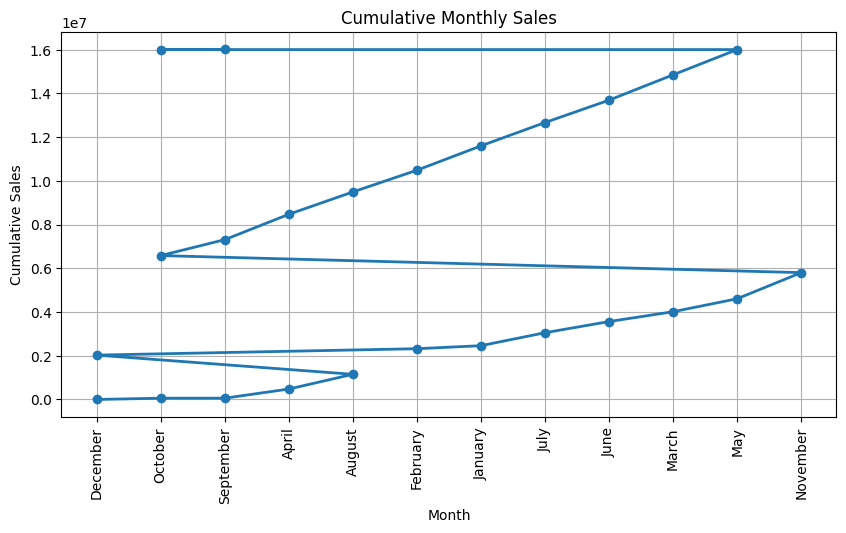

In [11]:
# Calculate the cumulative sales per month for each year.


import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt

# connect to database
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="ecommerce"
)

cur = conn.cursor()
query = """select years,months,payments,sum(payments)
over (order by years, months) cumulative_sales from
(select year(orders.order_purchase_timestamp) as years,
monthname(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payments from orders join payments 
on orders.order_id = payments.order_id
group by years,months order by years,months) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["years","months","payments","cumulative_sales"])
df

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))

plt.plot(df['months'], df['cumulative_sales'], marker='o', linewidth=2)

plt.xticks(rotation=90)
plt.xlabel("Month")
plt.ylabel("Cumulative Sales")
plt.title("Cumulative Monthly Sales")
plt.grid(True)

plt.show()




In [ ]:
# Calculate the year-over-year growth rate of total sales.
query = """
WITH a AS (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value),2) AS payments
    FROM orders 
    JOIN payments 
        ON orders.order_id = payments.order_id
    GROUP BY years
    ORDER BY years
)

SELECT 
    years,
    ((payments - LAG(payments) OVER (ORDER BY years)) 
     / LAG(payments) OVER (ORDER BY years)) * 100 AS yoy_growth_percent
FROM a
ORDER BY years;
"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["year","yoy_growth_percent"])
df



,year,yoy_growth_percent
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


In [37]:
#Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

query = """
WITH a AS (
    SELECT 
        customers.customer_id,
        MIN(orders.order_purchase_timestamp) AS first_order
    FROM customers
    JOIN orders 
        ON customers.customer_id = orders.customer_id
    GROUP BY customers.customer_id
),

b AS (
    SELECT 
        a.customer_id
    FROM a
    JOIN orders 
        ON orders.customer_id = a.customer_id
    WHERE orders.order_purchase_timestamp > a.first_order
      AND orders.order_purchase_timestamp <= DATE_ADD(a.first_order, INTERVAL 6 MONTH)
    GROUP BY a.customer_id
)

SELECT 
    ROUND(
        100.0 * COUNT(DISTINCT b.customer_id) 
        / COUNT(DISTINCT a.customer_id), 
    2) AS retention_rate
FROM a
LEFT JOIN b 
    ON a.customer_id = b.customer_id;
"""



cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["retention_rate"])
df



,retention_rate
0,0.00


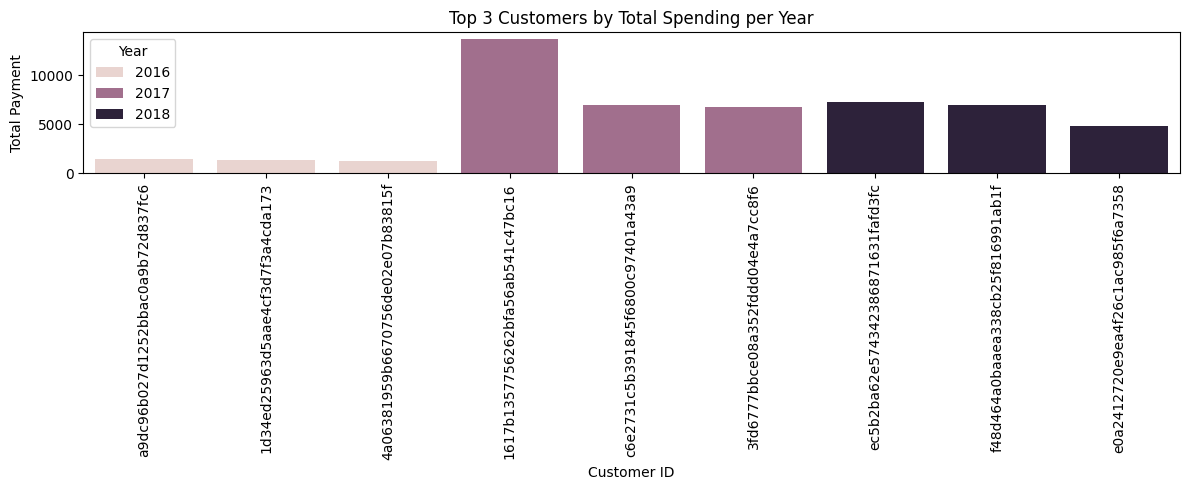

,Year,Id,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.550049,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.739990,2
2,2016,4a06381959b6670756de02e07b83815f,1227.780029,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.080078,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.310059,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.660156,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.879883,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.209961,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.439941,3


In [48]:
#Identify the top 3 customers with the highest total spending for each year.
import mysql.connector
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="root",
    database="ecommerce"
)
cur = conn.cursor()

query = """ 
SELECT *
FROM (
    SELECT 
        YEAR(o.order_purchase_timestamp) AS Year,
        o.customer_id AS Id,
        SUM(p.payment_value) AS Payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(o.order_purchase_timestamp)
            ORDER BY SUM(p.payment_value) DESC
        ) AS cust_rank
    FROM orders o
    JOIN payments p
        ON p.order_id = o.order_id
    GROUP BY 
        YEAR(o.order_purchase_timestamp),
        o.customer_id
) t
WHERE cust_rank <= 3;
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns=["Year","Id","Payment","Rank"])

plt.figure(figsize=(12,5))
sns.barplot(
    x="Id",
    y="Payment",
    data=df,
    hue="Year"
)

plt.title("Top 3 Customers by Total Spending per Year")
plt.xlabel("Customer ID")
plt.ylabel("Total Payment")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

df
